# Avsluttende programmerings prosjekt ProgMod
## Problemstillingen
* Hvordan kan vi bruke programmering til å modellere og simulere kunstig intelligens? 
* Hvilke faktorer påvirker læring, beslutningstaking og etikk? 
* Hvilke begrensninger har modellene dine, og drøft hva de forteller oss om kunstig intelligens

## Introduksjon til kunstig inteligens
Oxford ordboken definerer kunstig intelligens som “utviklingen av datasystemer i stand til å utføre oppgaver som normalt krever menneskelig intelligens, for eksempel visuell persepsjon, talegjenkjenning, beslutningstaking og oversettelse mellom språk”. Men flere av disse vanlige algoritmene og programmene klarer også å utføre disse oppgavene. Så hva er det som skiller kunstig intelligens fra vanlige datasystemer? Den store forskjellen mellom kunstig intelligens og vanlige programmer er at i vanlig programmering må vi finne mønstrene selv og programmere et system som bruker mønsteret. Med kunstig intelligens skjer utviklingen på en grunnleggende annen måte. Istedenfor å fortelle programmet nøyaktig hva det skal gjøre, gir vi det et datasett, og programmet finner mønstre selv. Ofte kan dette være mer effektivt enn den “gamle måten”, men det kan også ha ulemper, for eksempel ved å finne mønstre som ikke er relevante. Det kan også være partisk hvis datasettet ikke er representativt, og mønstrene AIen finner er derfor ikke representative. Et eksempel på dette er Amazons AI som hjalp dem med ansettelse. Den var partisk fordi den var basert på tidligere CV-er de hadde mottatt som da var mannsdominerte. Programmet anbefalte derfor menn oftere enn kvinner.<sup>[1]</sup> Kunstig intelligens er ikke en perfekt løsning på alt, og man må være klar over hvordan man bruker det på en ansvarlig måte. Men det betyr ikke at det ikke kan være nyttig hvis man forstår begrensningene og bygger rundt dem.



## Eksempler på maskinlæring
Under har jeg flere kodeeksempler. De bruker alle hver sin modell, type modell og måte å forutse data. De blir evaluert på nøyaktigheten sin avhenging av hvor høy treningsandelen er. Programmet kjører også hver modell flere ganger for å prøve å motvirke uteliggere der modellen fremstår bedre eller dårligere enn det den er til vanlig. Alle modellene trenses på et datasett om pingviner og skal prøve å bestemme arten til pingvinen basert på data om pingvinen. Det er beskrivelser av forskjellene på hver modell underveis. På slutten fremstiller er resultatene fremstilt grafisk.


In [28]:
# Import/define

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import neighbors, tree, ensemble, linear_model, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tensorflow.keras import layers


def map_string_to_number(s):
    # Define your custom mapping from strings to numbers here
    if s == 'Adelie' or s == 'MALE' or s == 'tree':
        return float(0)
    elif s == 'Chinstrap' or s == 'FEMALE' or s == 'RandomForestClassifier':
        return float(1)
    elif s == 'Gentoo' or s == 'LogisticRegression':
        return float(2)
    elif s == 'KNeighborsClassifier':
        return float(3)
    elif s == 'SVC':
        return float(4)
    elif s == 'NN':
        return float(5)
    elif type(s) == 'float':
        return s
    else:
        return 100
    
titles = {'model':[], 'treningsandel': [], 'accuracy': []}
model_eval = pd.DataFrame(titles)

test_amount = 40
test_amoun_nn = 10

### Decision Tree
En DecisionTreeClassifier er en modell der interne noder representerer egenskapene til et datasett. Det bruker da enkle regler for å følge ned det treet til den ender opp med et resultat. Det er en modell som er veldig lett å forstå og tolke. Man kan lett visualisere strukturen og logikken den bruker. I tillegg er den flink til å håndtere uteliggere og manglende verdier. Den fungerer bra på både små og store datasett. Det finnes deriomot også noen ulemper. En av hovedutfordringene er å finne den optimale dybden og bredden på treet. Hvis det er for lite kan det bomme viktige mønster. Hvis treet er for stort kan det overkorigere og være sensetiv til støy. Et valg-tre er også sensetive til endringer i treningsdataen, den kan ende opp med inkonsekvente trær.

In [29]:
# tree.DecisionTreeClassifier

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(1, 10):
    accuracy_list = []
    trainingsize_eval = i/10
    
    # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]
        
        model = tree.DecisionTreeClassifier()  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)

        precision = precision_score(testkategorier, predictions, average='macro')
        accuracy_list.append(precision)
        
    # Takes the average of 10 runs and adds it to the data frame for eval   
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['tree'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


### RandomForestClassifier
En RandomForestClassifier er basert på valg-trær. Den passer deler av dataen til forksjellig trær og kombinerer de til et gjennomsnitt. Dette forbedrer nøyaktigheten og prøver å kontrollere overtilpasning. Den er mye i bruk i både regression og klassifiserings problemer. Man får også flere av fordelene fra valg-tre som at den håndterer manglende data. Det er noen ulemper også. En av de største utfordringene er det samme som valg-tre, og det er å finne riktig bredde og dybde på treet.

In [30]:
# RandomForestClassifier

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(1, 10):
    accuracy_list = []
    trainingsize_eval = i/10
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]

        model = RandomForestClassifier()  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)
        
        precision = precision_score(testkategorier, predictions, average='macro')
        accuracy_list.append(precision)
    
    # Takes the average of 10 runs and adds it to the data frame for eval
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['RandomForestClassifier'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


### LogisticRegression
Logistisk regressjon er en statistisk metode som brukes for å passe en regressjonsmodell når responsvariabelen er binær. Den har en mindre tendens til å overtilpasse dataen og er bra med lineære data. Det er flere ulemper ved den logistik regresjon også. Hvis mengden observasjoner er mindre en mengde responsvariabler brude man ikke bruke logistisk regressjon fordi den da har en tendens til å overtilpasse. Den største ulempen med logistisk regresjon er at det er antat en lineæritet mellom variablene man gir den og resultatene man får tilbake.

In [31]:
# LogisticRegression

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(1, 10):
    accuracy_list = []
    trainingsize_eval = i/10
    
    # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]
        
        model = LogisticRegression(max_iter=2000)  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)
       
        precision = precision_score(testkategorier, predictions, average='macro')
        accuracy_list.append(precision)
    
    # Takes the average of 10 runs and adds it to the data frame for eval    
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['LogisticRegression'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


### KNeighborsClassifier
KNeighborsClassifier er en modell som er basert på at du gir den en K verdi og så ser den på nabo-punktene til den k verdien og utifra det bestemmer en respons. Noen av fordelene med den er at den er enkel å implementere og trenger ikke å trenes på alle datapunktene, i tilleg gjør den veldig lite prossesering før evalueringen som kan være praktisk i noen tilfeller. Noen av ulempene med den er at den optimale verdien til K kommer avhenger sterkt av dataen din, om k verdien er veldig høy eller lav vil den kunne ta med classifiseringer som ikke er relevante.

In [32]:
# KNeighborsClassifier

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(1, 10):
    accuracy_list = []
    trainingsize_eval = i/10
    
    # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]

        model = KNeighborsClassifier()  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)
        
        precision = precision_score(testkategorier, predictions, average='macro')
        accuracy_list.append(precision)

    # Takes the average of 10 runs and adds it to the data frame for eval        
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['KNeighborsClassifier'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


### SVC
SVC står for C-Support Vector Classification. Det er en type SVM som blir brukt i klassifikasjon. Den blomstrer når det er mangedimensjonaldata og kan være svært nøyaktig om man velger riktig kjerne. En stor ulempe med SVC er at tiden det tar å passe modellene øker eksponensielt med mengden med mengden data man gir den og SVC er derfor upraktisk med for store datasett.

In [33]:
# SVC

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']                         # labels

# A loop for testing different training sizes
for i in range(1, 10):
    accuracy_list = []
    trainingsize_eval = i/10

    # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
    for j in range (test_amount):
        ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)

        training_criteria = ml_data[0]
        test_criteria = ml_data[1]
        training_categories = ml_data[2]
        testkategorier = ml_data[3]

        model = SVC()  # Makes the model
        model.fit(training_criteria, training_categories)   # Trains the model

        predictions = model.predict(test_criteria)

        precision = precision_score(testkategorier, predictions, average='macro', zero_division=1)
        accuracy_list.append(precision)
    
    # Takes the average of 10 runs and adds it to the data frame for eval
    accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
    data = pd.DataFrame({'model':['SVC'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
    model_eval = pd.concat([model_eval, data], ignore_index=True)


### Nevralt Nett
This neural network model works by taking in input data (in this case, the penguin features such as bill length, bill depth, flipper length, and body mass) and passing it through the layers of the network. In each layer, the data is transformed by a series of weighted connections between the neurons and an activation function. The first layer uses a sigmoid activation function, which squashes the input values into a range between 0 and 1. The second layer uses a linear activation function, which means that the output of the layer is a weighted sum of its inputs.

The model is trained on a dataset of penguin data by adjusting the weights of the connections between the neurons to minimize the mean squared error between the predicted species and the true species. This is done using an optimization algorithm called Adam with a learning rate of 0.1.

Once the model is trained, it can be used to make predictions on new data by passing the data through the layers of the network and computing the output of the final layer.

Is there anything else you would like to know?

In [34]:
# Nevral Nett

pingvindata = pd.read_csv("C:\\Users\\elias\\Documents\\GitHub_loc\\ModelleringII\\penguings.txt", delimiter = ",")

pingvindata['species'] = pingvindata['species'].map(map_string_to_number)
pingvindata['sex'] = pingvindata['sex'].map(map_string_to_number)

model = tf.keras.Sequential()
model.add(layers.Dense(10, activation="sigmoid", input_shape=(4,)))
model.add(layers.Dense(1, activation="linear"))

total_iterations = 9 * 10

criteria = pingvindata[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] # features
categories = pingvindata['species']

# Adds a progressbar
with tqdm(total=total_iterations, desc="Training") as pbar:
    # A loop for testing different training sizes
    for i in range(1, 10):
        accuracy_list = []
        trainingsize_eval = i/10
        
        # Runs the model 10 times and takes the average score for the same training size to try to eliminate outliers
        for j in range(test_amoun_nn):
            model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
                loss='mean_squared_error',
                metrics=['accuracy']) 
            
            
            ml_data = train_test_split(criteria, categories, train_size=trainingsize_eval, random_state=42)
            x = ml_data[0]
            X_test = ml_data[1]
            y = ml_data[2]
            y_test = ml_data[3]            

            model.fit(x, y, epochs=150, verbose=0)

            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

            accuracy_list.append(accuracy)
            
            pbar.update(1)

        # Takes the average of 10 runs and adds it to the data frame for eval
        accuracy_avrg = sum(accuracy_list) / len(accuracy_list)
        data = pd.DataFrame({'model':['NN'], 'treningsandel': [trainingsize_eval], 'accuracy': [accuracy_avrg]})
        model_eval = pd.concat([model_eval, data], ignore_index=True)


Training: 100%|██████████| 90/90 [02:01<00:00,  1.35s/it]


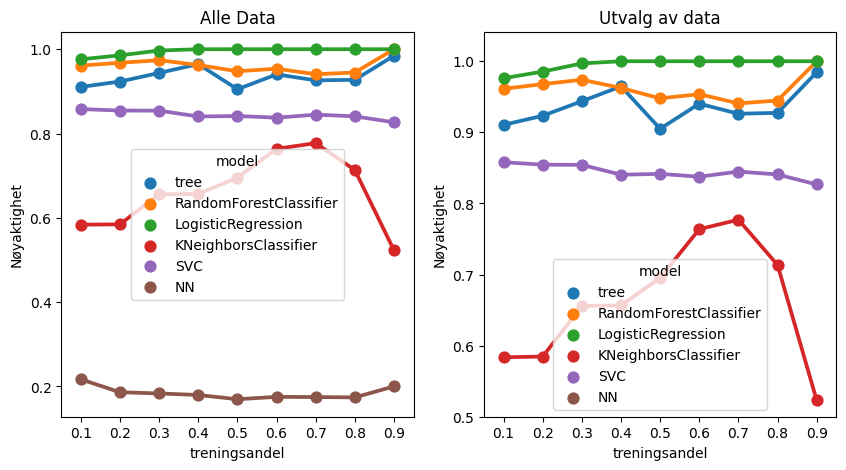

In [35]:
# Modell evaluering
model_eval_plot = model_eval.copy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Makes a plot with all the data
sns.pointplot(data=model_eval_plot, x='treningsandel', y='accuracy', hue='model', ax=ax1)
ax1.set_title('Alle Data')
ax1.set_ylabel('Nøyaktighet')

# Makes plot with exerpt of data
sns.pointplot(data=model_eval_plot, x='treningsandel', y='accuracy', hue='model', ax=ax2)
ax2.set_title("Utvalg av data")
ax2.set_ylabel('Nøyaktighet')
ax2.set_ylim(0.5)

# Show the plot
plt.show()


## Kunstig inteligens i dag
Kunstig intelligens (KI) har blitt stadig mer utbredt i dagens samfunn og har mange bruksområder, inkludert chat-modeller. Chat-modeller er en type KI som brukes til å simulere en samtale mellom mennesker og maskiner. Disse modellene kan brukes til å automatisere kundeservice og gi raskere svar på spørsmål fra kunder.

Det er imidlertid også bekymringer knyttet til bruken av KI i chat-modeller og andre applikasjoner. For eksempel kan KI-systemer være sårbare for angrep og manipulasjon, og det kan være vanskelig å avgjøre om en samtale skjer mellom et menneske eller en maskin. Det er også bekymringer knyttet til personvern og sikkerhet når det gjelder innsamling og bruk av data i KI-systemer.

Når det gjelder ChatGPT, er dette en modell som ble utviklet av OpenAI for å simulere samtaler mellom mennesker og maskiner. Microsoft integrerte denne modellen i Bing for å gi brukerne bedre søkemotorer og anbefalingssystemer. Selv om ChatGPT har gjort det mulig for den gjennomsnittlige forbrukeren å bruke AI i det daglige livet sitt, har det også vært noen utfordringer med modellen. For eksempel var GPT-3-modellen som ChatGPT var basert på, trent på eldre data og var optimalisert for samtaleflyt og ikke nøyaktighet. Dette førte til at modellen slet med matematikk og fant opp fakta. Microsoft integrerte senere OpenAI sin GPT-3-modell i Bing for å gi brukerne bedre søkemotorer og anbefalingssystemer.


En bekymring som har kommet frem etter at chat-modeller ble populære er at forbrukere kan ha urealistiske forventninger til hva KI kan gjøre. For eksempel kan noen forbrukere tro at KI-systemer kan løse alle problemer eller gi nøyaktige svar på alle spørsmål. Dette kan føre til at forbrukere tar beslutninger basert på feilaktig informasjon eller at de blir skuffet når KI-systemer ikke fungerer som forventet. Chat-modeller er er ofte veldig selvsikre selv når de har feil, noe som kan føre til at forburkere bil villedet.

## Fotnoter
<sup id=“fn1”>[1]</sup> The Guardian

<span id="fn2"> footnote 1</span>